# Imports

In [1]:
import os, csv, argparse, wget, sys, IPython
os.environ['TORCH_HOME'] = '/mnt/g/My Drive/Thesis/src/pretrained'
import torch, torchaudio, timm, csv, json, os.path, random, PIL
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional
from torch.utils.data import Dataset
import torchvision.transforms as T
import numpy as np
from torch.cuda.amp import autocast
from sklearn import metrics
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path='/mnt/g/My Drive/Thesis/src/data/vgg_class.csv'
csvFile=pd.read_csv(path, index_col=0)
from src.cavmaemodels import *

# Functions

In [2]:
class Block(torch.nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=torch.nn.GELU, norm_layer=torch.nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.norm1_a = norm_layer(dim)
        self.norm1_v = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else torch.nn.Identity()
        self.norm2 = norm_layer(dim)
        self.norm2_a = norm_layer(dim)
        self.norm2_v = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, modality=None):
        if modality == None:
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        elif modality == 'a':
            x = x + self.drop_path(self.attn(self.norm1_a(x)))
            x = x + self.drop_path(self.mlp(self.norm2_a(x)))
        elif modality == 'v':
            x = x + self.drop_path(self.attn(self.norm1_v(x)))
            x = x + self.drop_path(self.mlp(self.norm2_v(x)))
        return x

def return_masked(input_file):

    x_masked = input_file
    y=list()
    for i in range(mask.shape[1]):
        if mask[0][i].item()==1.0:
            y.append(torch.zeros(x_masked.shape[2]))
        if mask[0][i].item()==0.0:
            y.append(torch.flatten(x_masked[:,ids_restore[0][i].item():ids_restore[0][i].item()+1]))

    x = torch.stack(y,dim=0).unsqueeze(0)
    return x

def show_image(image,title=''):
    if image.shape[0] == 3:
        image = torch.einsum('chw->hwc', image)
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.imshow(torch.clip((image) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    return

def make_index_dict(d):

    l = np.array([i[1] for i in d['data']])
    unique_index = np.unique(l, return_index = True)[-1]
    unique_l = [l[i] for i in sorted(unique_index)]

    index_lookup=dict()
    for c,i in enumerate(unique_l):
        index_lookup[i]=str(c)

    return index_lookup




def make_name_dict(label_csv):
    name_lookup = {}
    with open(label_csv, 'r') as f:
        csv_reader = csv.DictReader(f)
        line_count = 0
        for row in csv_reader:
            name_lookup[row['index']] = row['display_name']
            line_count += 1
    return name_lookup

def lookup_list(index_list, label_csv):
    label_list = []
    table = make_name_dict(label_csv)
    for item in index_list:
        label_list.append(table[item])
    return label_list

def preemphasis(signal,coeff=0.97):
    """perform preemphasis on the input signal.
    :param signal: The signal to filter.
    :param coeff: The preemphasis coefficient. 0 is none, default 0.97.
    :returns: the filtered signal.
    """
    return np.append(signal[0],signal[1:]-coeff*signal[:-1])

class AudiosetDataset(Dataset):
    def __init__(self, dataset_json_file, audio_conf, label_csv=None, verbose=False):
        if verbose:
            print(f"{'*'*20} Dataset Stats {'*'*20}")
            print()
        self.datapath = dataset_json_file
        with open(dataset_json_file, 'r') as fp:
            data_json = json.load(fp)
        self.data = data_json['data']
        self.data = self.pro_data(self.data)
        if verbose:
            print(f"\tNumber of samples: {self.data.shape[0]}")
        self.num_samples = self.data.shape[0]
        self.audio_conf = audio_conf
        self.label_smooth = self.audio_conf.get('label_smooth', 0.0)
        if verbose:
            print('\tUsing Label Smoothing: ' + str(self.label_smooth))
        self.melbins = self.audio_conf.get('num_mel_bins')
        self.freqm = self.audio_conf.get('freqm', 0)
        self.timem = self.audio_conf.get('timem', 0)
        if verbose:
            print('\tnow using following mask: {:d} freq, {:d} time'.format(self.audio_conf.get('freqm'), self.audio_conf.get('timem')))
        self.mixup = self.audio_conf.get('mixup', 0)
        if verbose:
            print(f"\tMixup rate: {self.mixup}")
        self.dataset = self.audio_conf.get('dataset')
        # dataset spectrogram mean and std, used to normalize the input
        self.norm_mean = self.audio_conf.get('mean')
        self.norm_std = self.audio_conf.get('std')
        # skip_norm is a flag that if you want to skip normalization to compute the normalization stats using src/get_norm_stats.py, if Ture, input normalization will be skipped for correctly calculating the stats.
        # set it as True ONLY when you are getting the normalization stats.
        self.skip_norm = self.audio_conf.get('skip_norm') if self.audio_conf.get('skip_norm') else False
        if verbose:
            if self.skip_norm:
                print('\tnow skip normalization (use it ONLY when you are computing the normalization stats).')
            else:
                print('\tuse dataset mean {:.3f} and std {:.3f} to normalize the input.'.format(self.norm_mean, self.norm_std))

        # if add noise for data augmentation
        self.noise = self.audio_conf.get('noise', False)
        if verbose:
            if self.noise == True:
                print(f"\tNoise augmentation: True")
            else:
                print(f"\tNoise augmentation: False")

        self.index_dict = make_index_dict(data_json)
        if len(self.index_dict) == 57:
            self.label_num = len(self.index_dict)
        else:
            self.label_num = 57
        if verbose:
            print(f"\tNumber of classes: {self.label_num}")

        self.target_length = self.audio_conf.get('target_length')

        # train or eval
        self.mode = self.audio_conf.get('mode')
        if verbose:
            print(f"\tMode: {self.mode}")

        # set the frame to use in the eval mode, default value for training is -1 which means random frame
        self.frame_use = self.audio_conf.get('frame_use', -1)
        # by default, 10 frames are used
        self.total_frame = self.audio_conf.get('total_frame', 10)
        if verbose:
            print(f"\tTotal number of frames used: {self.total_frame}, starting from index: {self.frame_use}")

        # by default, all models use 224*224, other resolutions are not tested
        self.im_res = self.audio_conf.get('im_res', 224)
        if verbose:
            print(f"\tConverted image shape: [{self.im_res},{self.im_res}]")
        self.preprocess = T.Compose([
            T.Resize(self.im_res, interpolation=PIL.Image.BICUBIC),
            T.CenterCrop(self.im_res),
            T.ToTensor(),
            T.Normalize(
                mean=[0.4850, 0.4560, 0.4060],
                std=[0.2290, 0.2240, 0.2250]
            )])
        print()

    # change python list to numpy array to avoid memory leak.
    def pro_data(self, data_json):
        for i in range(len(data_json)):
            data_json[i] = [data_json[i]['wav'], data_json[i]['label'], data_json[i]['video_id'], data_json[i]['video_path']]
        data_np = np.array(data_json, dtype=str)
        return data_np

    # reformat numpy data to original json format, make it compatible with old code
    def decode_data(self, np_data):
        datum = {}
        datum['wav'] = np_data[0]
        datum['labels'] = np_data[1]
        datum['video_id'] = np_data[2]
        datum['video_path'] = np_data[3]
        return datum

    def get_image(self, filename, filename2=None, mix_lambda=1):
        if filename2 == None:
            img = Image.open(filename)
            image_tensor = self.preprocess(img)
            return image_tensor
        else:
            img1 = Image.open(filename)
            image_tensor1 = self.preprocess(img1)

            img2 = Image.open(filename2)
            image_tensor2 = self.preprocess(img2)

            image_tensor = mix_lambda * image_tensor1 + (1 - mix_lambda) * image_tensor2
            return image_tensor

    def _wav2fbank(self, filename, filename2=None, mix_lambda=-1):
        # no mixup
        if filename2 == None:
            waveform, sr = torchaudio.load(filename)
            waveform = waveform - waveform.mean()
        # mixup
        else:
            waveform1, sr = torchaudio.load(filename)
            waveform2, _ = torchaudio.load(filename2)

            waveform1 = waveform1 - waveform1.mean()
            waveform2 = waveform2 - waveform2.mean()

            if waveform1.shape[1] != waveform2.shape[1]:
                if waveform1.shape[1] > waveform2.shape[1]:
                    # padding
                    temp_wav = torch.zeros(1, waveform1.shape[1])
                    temp_wav[0, 0:waveform2.shape[1]] = waveform2
                    waveform2 = temp_wav
                else:
                    # cutting
                    waveform2 = waveform2[0, 0:waveform1.shape[1]]

            mix_waveform = mix_lambda * waveform1 + (1 - mix_lambda) * waveform2
            waveform = mix_waveform - mix_waveform.mean()

        try:
            fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False, window_type='hanning', num_mel_bins=self.melbins, dither=0.0, frame_shift=10)
        except:
            fbank = torch.zeros([512, 128]) + 0.01
            print('there is a loading error')

        target_length = self.target_length
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]

        return fbank

    def randselect_img(self, video_id, video_path):
        if self.mode == 'eval':
            # if not specified, use the middle frame
            if self.frame_use == -1:
                frame_idx = int((self.total_frame) / 2)
            else:
                print(f"\t\t\t frame_use: {self.frame_use}")
                frame_idx = self.frame_use
        else:
            frame_idx = random.randint(0, 9)
            #print(f"frame_idx: {frame_idx}")
        while os.path.exists(video_path + '/frame_' + str(frame_idx) + '/' + video_id + '.jpg') == False and frame_idx >= 1:

            #print(f"\tvideo_id: {video_id} and frame_idx: {frame_idx} does not exist. Full loc: {video_path + '/frame_' + str(frame_idx) + '/' + video_id + '.jpg'}")
            frame_idx -= 1
        out_path = video_path + '/frame_' + str(frame_idx) + '/' + video_id + '.jpg'
        #print(f"\t\nout_path: {out_path}")
        return out_path

    def __getitem__(self, index):
        if random.random() < self.mixup:
            datum = self.data[index]
            datum = self.decode_data(datum)
            mix_sample_idx = random.randint(0, self.num_samples-1)
            mix_datum = self.data[mix_sample_idx]
            mix_datum = self.decode_data(mix_datum)
            mix_lambda = np.random.beta(10, 10)
            try:
                fbank = self._wav2fbank(os.getcwd()+"/src"+str(datum['wav']), mix_datum['wav'], mix_lambda)
            except:
                fbank = torch.zeros([self.target_length, 128]) + 0.01
                #print('0 - there is an error in loading audio')
            try:
                image = self.get_image(self.randselect_img(datum['video_id'], datum['video_path']), self.randselect_img(mix_datum['video_id'], datum['video_path']), mix_lambda)
            except:
                image = torch.zeros([3, self.im_res, self.im_res]) + 0.01
                #print('0 - there is an error in loading image')
            label_indices = np.zeros(self.label_num) + (self.label_smooth / self.label_num)
            for label_str in datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] += mix_lambda * (1.0 - self.label_smooth)
            for label_str in mix_datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] += (1.0 - mix_lambda) * (1.0 - self.label_smooth)
            label_indices = torch.FloatTensor(label_indices)

        else:

            datum = self.data[index]
            datum = self.decode_data(datum)
            # label smooth for negative samples, epsilon/label_num
            label_indices = np.zeros(self.label_num) + (self.label_smooth / self.label_num)
            #print(f"1. a zero vector of shape: {label_indices.shape}")
            try:
            #    print(f"2.1 load and preprocess wav2fbank.")
                # main load the audio ###############################################
                fbank = self._wav2fbank(os.getcwd()+"/src"+str(datum['wav']), None, 0)
            except:
                fbank = torch.zeros([self.target_length, 128]) + 0.01
                print('1 - there is an error in loading audio')
            try:
            #    print(f"2.2 load and preprocess image.")

                # main load the video ###############################################
                image = self.get_image(self.randselect_img(datum['video_id'], os.getcwd()+"/src"+datum['video_path']), None, 0)
            except:
                image = torch.zeros([3, self.im_res, self.im_res]) + 0.01
                print('1 - there is an error in loading image')
            
            for label_str in datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] = 1.0 - self.label_smooth
                
            #print(label_indices)
            label_indices = torch.FloatTensor(label_indices)

        # SpecAug, not do for eval set
        freqm = torchaudio.transforms.FrequencyMasking(self.freqm)
        timem = torchaudio.transforms.TimeMasking(self.timem)
        fbank = torch.transpose(fbank, 0, 1)
        fbank = fbank.unsqueeze(0)
        if self.freqm != 0:
            fbank = freqm(fbank)
        if self.timem != 0:
            fbank = timem(fbank)
        fbank = fbank.squeeze(0)
        fbank = torch.transpose(fbank, 0, 1)

        # normalize the input for both training and test
        if self.skip_norm == False:
            fbank = (fbank - self.norm_mean) / (self.norm_std)
        # skip normalization the input ONLY when you are trying to get the normalization stats.
        else:
            pass

        if self.noise == True:
            fbank = fbank + torch.rand(fbank.shape[0], fbank.shape[1]) * np.random.rand() / 10
            fbank = torch.roll(fbank, np.random.randint(-self.target_length, self.target_length), 0)

        # fbank shape is [time_frame_num, frequency_bins], e.g., [1024, 128]
        return fbank, image, label_indices, datum['labels']

    def __len__(self):
        return self.num_samples
    
    
def return_masked(input_file, mask,ids_restore):

    x_masked = input_file
    y=list()
    for i in range(mask.shape[1]):
        if mask[0][i].item()==1.0:
            y.append(torch.zeros(x_masked.shape[2]))
        if mask[0][i].item()==0.0:
            y.append(torch.flatten(x_masked[:,ids_restore[0][i].item():ids_restore[0][i].item()+1]).cpu())

    x = torch.stack(y,dim=0).unsqueeze(0)
    return x


In [3]:
from timm.models.vision_transformer import PatchEmbed

def random_masking(x, mask_ratio):

    N, L, D = x.shape  # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))

    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=1)

    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, mask, ids_restore

def load_image(img_loc):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = Image.open(img_loc)
    img = img.resize((224, 224))
    img = np.array(img) / 255.
    img = img - imagenet_mean
    img = img / imagenet_std
    img = torch.Tensor(img)
    return img


def unpatchify(x):
    patch_embed = PatchEmbed(224, 16, 3, 1024)
    num_patches = patch_embed.num_patches
    p = patch_embed.patch_size[0]
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]

    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    img = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return img

def patchify(imgs):
    patch_embed = PatchEmbed(224, 16, 3, 1024)
    num_patches = patch_embed.num_patches
    p = patch_embed.patch_size[0] #
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

# Testing the models

In [5]:
model = CAVMAE()
test_input_a = torch.rand([1, 1024, 128])
test_input_v = torch.rand([1, 3, 224, 224])

loss, loss_mae, loss_mae_a, ids_restore_a, loss_mae_v, ids_restore_v, loss_c, mask_a, mask_v, c_acc, pred_a, pred_v, a_bare, v_bare = model(test_input_a, test_input_v,info=True)
model.eval()


**************************************************
None
		Encoder initiated
aaaaaaaaaaaaaaaaaaaa
		 ==> step 1.1: raw audio shape: torch.Size([1, 1024, 128])
		 ==> step 1.2: patch embdding: torch.Size([1, 512, 768])
		 ==> step 1.3: position/modality added: torch.Size([1, 512, 768])
vvvvvvvvvvvvvvvvvvvv
		 ==> step 2.1: raw video shape: torch.Size([1, 3, 224, 224])
		 ==> step 2.2: patch embdding: torch.Size([1, 196, 768])
		 ==> step 2.3: position/modality added: torch.Size([1, 196, 768])
		 ==> step 3: Masking
		 ==> step 3.1: audio after masking: torch.Size([1, 128, 768])
		 ==> step 3.2: video after masking: torch.Size([1, 49, 768])
		 ==> step 4: Transformers
		 ==> step 4: audio after masking: (torch.Size([1, 128, 768]), 0)
		 ==> step 4: audio after masking: (torch.Size([1, 128, 768]), 1)
		 ==> step 4: audio after masking: (torch.Size([1, 128, 768]), 2)
		 ==> step 4: audio after masking: (torch.Size([1, 128, 768]), 3)
		 ==> step 4: audio after masking: (torch.Size([1, 128, 

CAVMAE(
  (patch_embed_a): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (patch_embed_v): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks_a): ModuleList(
    (0-10): 11 x Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm1_a): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm1_v): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2_a): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2_v): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Ml

In [6]:
model = CAVMAEFT(label_dim=57)
test_input_a = torch.rand([1, 1024, 128])
test_input_v = torch.rand([1, 3, 224, 224])

test_output = model(test_input_a, test_input_v, mode="multimodal",info=True)
print(f"test_output.shape: {test_output.shape}")
model.eval()

Use norm_pix_loss:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])

**************************************************
None
aaaaaaaaaaaaaaaaaaaa
		 ==> step 1: raw audio shape: torch.Size([1, 1024, 128])
		 ==> step 2: ready for patch embdding: torch.Size([1, 1, 128, 1024])
		 ==> step 3: after patch embdding: torch.Size([1, 512, 768])
		 ==> step 4: position/modality are added: torch.Size([1, 512, 768])
vvvvvvvvvvvvvvvvvvvv
		 ==> step 1: raw video shape: torch.Size([1, 3, 224, 224])
		 ==> step 1: video ready for patch embedding
		 ==> step 2: after patch embedding: torch.Size([1, 196, 768])
		 ==> step 3: position/modality are added: torch.Size([1, 196, 768])
aaaaaaaaaaaaaaaaaaaa
		audio is ready to be fed to transformers
vvvvvvvvvvvvvvvvvvvv
		video is ready to be fed to transformers
uuuuuuuuuuuuuuuuuuuu
		audio and video are concatenated
		now fed to a 

CAVMAEFT(
  (patch_embed_a): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (patch_embed_v): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks_a): ModuleList(
    (0-10): 11 x Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm1_a): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm1_v): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2_a): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2_v): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): 

# Loading the models

In [17]:
model = CAVMAE(audio_length=1024,modality_specific_depth=11)
model = torch.nn.DataParallel(model)
#mdl_weight = torch.load(args.pretrain_path, map_location=torch.device('cpu'))
#sd = torch.load('/mnt/g/My Drive/Thesis/src/pretrained/best_cavmae_model_ss.pth', map_location=device)
sd = torch.load('/mnt/g/My Drive/Thesis/src/pretrained/cav-mae-scale++.pth', map_location=device)

model.load_state_dict(sd)

<All keys matched successfully>

# self-supervised

In [18]:
audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 48, 'timem': 192, 'mixup': 0.0, 'dataset': 'vggsound', 'mode':'train', 'mean':-5.081, 'std':4.4849, 'noise':False, 'label_smooth': 0}# , 'im_res': im_res
tr = '/mnt/g/My Drive/Thesis/src/TEST.json'

tr_loader = torch.utils.data.DataLoader(AudiosetDataset(tr, label_csv=csvFile, audio_conf=audio_conf, verbose=False),
             batch_size=1, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)


masking_ratio=0.75
mae_loss_weight=1.0
contrast_loss_weight=0.01
mask_mode='unstructured'
with torch.no_grad():
    for i, (a_input, v_input, label_index, labels) in enumerate(tr_loader):
        a = a_input.to(device)
        v = v_input.to(device)
        with autocast():
            loss, loss_mae, loss_mae_a, ids_restore_a, loss_mae_v, ids_restore_v, loss_c, mask_a, mask_v, c_acc, pred_a, pred_v, a_bare, v_bare = model(a, v, masking_ratio, masking_ratio, mae_loss_weight=mae_loss_weight, contrast_loss_weight=contrast_loss_weight, mask_mode=mask_mode)


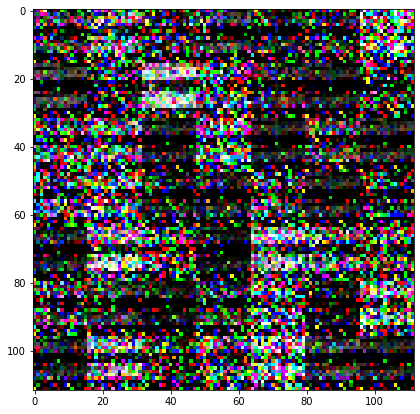

In [7]:
x=unpatchify(v_bare).squeeze(0)
show_image(x.data.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


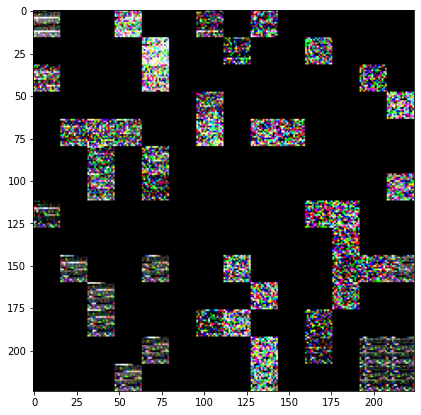

In [8]:
m_m = unpatchify(return_masked(v_bare,mask_v,ids_restore_v)).squeeze(0)
m_m = torch.einsum('chw->hwc', m_m)

plt.imshow(m_m)

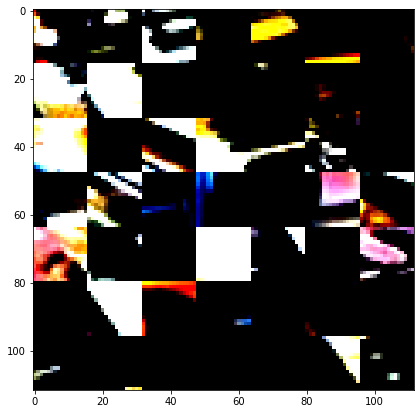

In [10]:
def unpatchify(x):
    patch_embed = PatchEmbed(224, 16, 3, 1024)
    num_patches = patch_embed.num_patches
    p = patch_embed.patch_size[0]
    h = w = int(x.shape[1]**.5)
    #print(f"h:{h}, w:{w}")
    #assert h * w == x.shape[1]
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    img = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return img

img_path = '/mnt/g/My Drive/Thesis/src/sample_frames/frame_0/fTgYZb_80lU_000096.jpg'
img = load_image(img_path)
x = img.unsqueeze(0)
x = torch.einsum('nhwc->nchw', x)
x = patchify(x)
x_masked, mask, ids_restore = random_masking(x,mask_ratio=.75)

x=unpatchify(x_masked).squeeze(0)
show_image(x.data.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


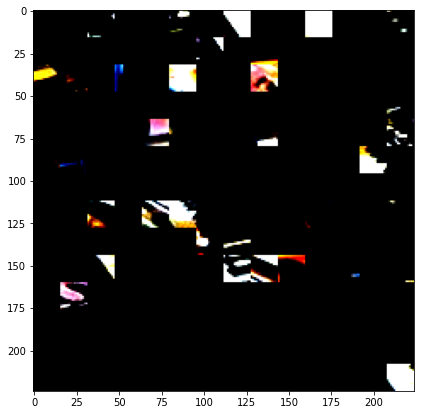

In [11]:
m_m = unpatchify(return_masked(x_masked,mask_v,ids_restore_v)).squeeze(0)
m_m = torch.einsum('chw->hwc', m_m)

plt.imshow(m_m)

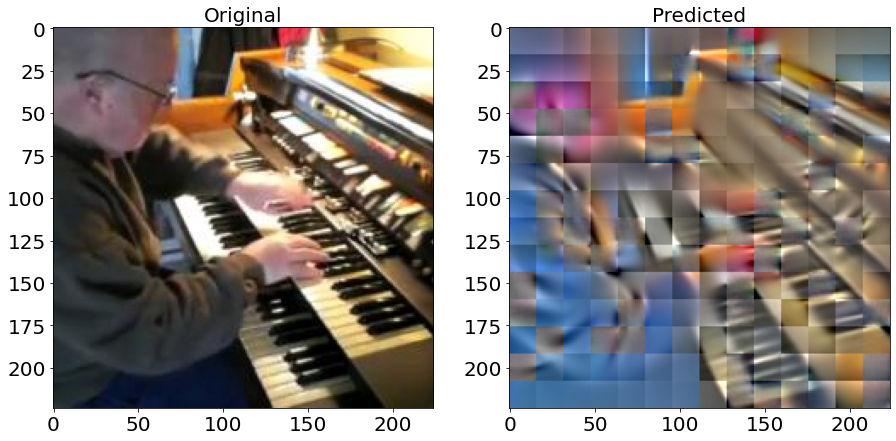

In [19]:

def unpatchify(x):
    patch_embed = PatchEmbed(224, 16, 3, 1024)
    num_patches = patch_embed.num_patches
    p = patch_embed.patch_size[0]
    h = w = int(x.shape[1]**.5)
    #print(f"h:{h}, w:{w}")
    #assert h * w == x.shape[1]
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    img = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return img

invTrans = T.Compose([T.Normalize(mean = [ 0., 0., 0. ],
                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                       T.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                        std = [ 1., 1., 1. ]), ])

inv_ten = invTrans(v_input)
original = torch.einsum('nchw->nhwc', inv_ten).squeeze(0)


fig, ax = plt.subplots(1, 2, figsize=(15, 15))


ax[0].imshow(original)
ax[0].tick_params(axis='x', labelsize=20)
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_title('Original', fontsize=20)

x = unpatchify(pred_v)
x = invTrans(x)
x = torch.einsum('nchw->nhwc', x).squeeze(0)
ax[1].imshow(torch.clip((x.data.cpu()) * 255, 0, 255).int())
ax[1].tick_params(axis='x', labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)
ax[1].set_title('Predicted', fontsize=20)

plt.show()

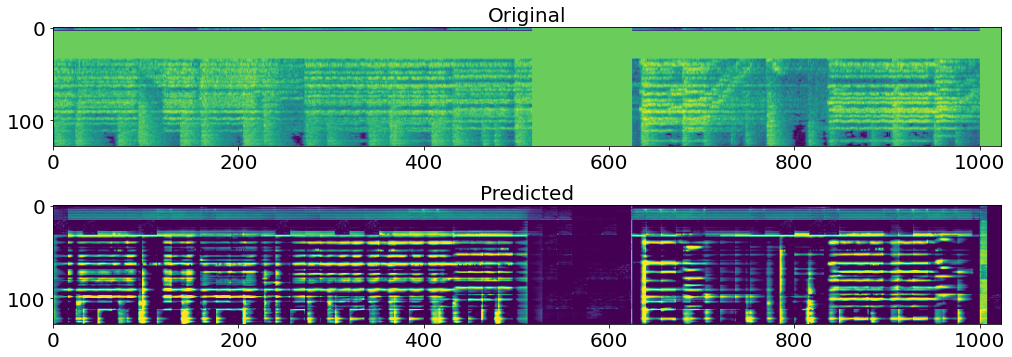

In [20]:
from timm.models.vision_transformer import PatchEmbed

def unpatchify(x):
    patch_embed = PatchEmbed(224, 16, 3, 1024)
    num_patches = patch_embed.num_patches
    p = patch_embed.patch_size[0]
    h = 8
    w = 64
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 1))
    x = torch.einsum('nhwpqc->nchpwq', x)
    img = x.reshape(shape=(x.shape[0], 1, h * p, w * p))
    return img



fig, ax = plt.subplots(2, 1, figsize=(17, 6))

ax[0].imshow(a_input.reshape(1024, 128).T)
ax[0].tick_params(axis='x', labelsize=20)
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_title('Original', fontsize=20)

x = unpatchify(pred_a)
x = torch.einsum('nchw->nhwc', x).squeeze(0)
ax[1].imshow(torch.clip((x.data.cpu()) * 255, 0, 255).int())
ax[1].tick_params(axis='x', labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)
ax[1].set_title('Predicted', fontsize=20)

plt.show()

In [ ]:

audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0.0, 'dataset': 'vggsound', 'mode':'train', 'mean':-5.081, 'std':4.4849, 'noise':True, 'label_smooth': 0}# , 'im_res': im_res
tr = '/mnt/g/My Drive/Thesis/src/TEST.json'

tr_loader = torch.utils.data.DataLoader(AudiosetDataset(tr, label_csv=csvFile, audio_conf=audio_conf, verbose=False),
             batch_size=1, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

from sklearn import metrics
loss_fn = torch.nn.CrossEntropyLoss()
softmax = torch.nn.Softmax(dim=1)
model = torch.nn.DataParallel(resnet50)
model = model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for i, (a_input, v_input, label_index, labels) in enumerate(tr_loader):
    a = a_input.to(device)
    target = label_index.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()
    print(f"loss: {loss}")

# CF

In [85]:
model = CAVMAEFT(label_dim=57)
if not isinstance(model, torch.nn.DataParallel):
    model = torch.nn.DataParallel(model)
sd = torch.load('/mnt/g/My Drive/Thesis/src/pretrained/best_audio_model_ft.pth', map_location=device)
model.load_state_dict(sd, strict=False)

audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0.0, 'dataset': 'vggsound', 'mode':'train', 'mean':-5.081, 'std':4.4849, 'noise':True, 'label_smooth': 0}# , 'im_res': im_res
tr = '/mnt/g/My Drive/Thesis/src/TEST.json'

tr_loader = torch.utils.data.DataLoader(AudiosetDataset(tr, label_csv=csvFile, audio_conf=audio_conf, verbose=False),
             batch_size=1, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

from sklearn import metrics
loss_fn = torch.nn.CrossEntropyLoss()
softmax = torch.nn.Softmax(dim=1)
with torch.no_grad():
    for i, (a_input, v_input, label_index, labels) in enumerate(tr_loader):
        a = a_input.to(device)
        v = v_input.to(device)
        target = label_index.to(device)
        with autocast():
            output = model(a, v, mode="multimodal",info=False)
            output = torch.sigmoid(output)

        predictions = output[jc].data.cpu().numpy()
        sorted_indexes = np.argsort(predictions)[::-1]
        for k in range(9):
            print('- P: {}: {:.4f}'.format(csvFile.iloc[sorted_indexes[k]]['display_name'], predictions[sorted_indexes[k]]))
        break
                

Use norm_pix_loss:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])

- P: steel_guitar: 0.9980
- P: acoustic_guitar: 0.9907
- P: harmonica: 0.7178
- P: tympani: 0.6953
- P: congas: 0.6382
- P: tambourine: 0.6299
- P: electric_guitar: 0.6270
- P: mandolin: 0.6265
- P: sitar: 0.6250


In [36]:
audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0.0, 'dataset': 'vggsound', 'mode':'train', 'mean':-5.081, 'std':4.4849, 'noise':True, 'label_smooth': 0}# , 'im_res': im_res
tr = '/mnt/g/My Drive/Thesis/src/TEST.json'

tr_loader = torch.utils.data.DataLoader(AudiosetDataset(tr, label_csv=csvFile, audio_conf=audio_conf, verbose=False),
             batch_size=1, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

from sklearn import metrics
loss_fn = torch.nn.CrossEntropyLoss()
softmax = torch.nn.Softmax(dim=1)
with torch.no_grad():
    for i, (a_input, v_input, label_index, labels) in enumerate(tr_loader):
        a = a_input.to(device)
        v = v_input.to(device)
        target = label_index.to(device)
        with autocast():
            output = model(a, v, mode="multimodal",info=False)
            loss = loss_fn(output, target)
            y_pred=np.argmax(output.data.cpu().numpy(), axis=1)
            y_test=np.argmax(target.data.cpu().numpy(), axis=1)
            acc = metrics.accuracy_score(y_pred, y_test)
            print(f"- Loss: {loss}, Actual: {y_test}, Predicted: {y_pred}, Accuracy: {acc}")
        for jc in range(output.shape[0]):
            predictions = output[jc].data.cpu().numpy()
            sorted_indexes = np.argsort(predictions)[::-1]
            for k in range(1):
                print('- P: {}: {:.4f}, T: {}'.format(csvFile.iloc[sorted_indexes[k]]['display_name'], predictions[sorted_indexes[k]], labels[jc]))
                print()
                


- Loss: 7.03515625, Actual: [0], Predicted: [12], Accuracy: 0.0
- P: steel_guitar: 5.9609, T: steel_guitar

- Loss: 6.75390625, Actual: [1], Predicted: [26], Accuracy: 0.0
- P: flute: 5.4062, T: flute

- Loss: 6.13671875, Actual: [2], Predicted: [17], Accuracy: 0.0
- P: didgeridoo: 5.8164, T: didgeridoo

- Loss: 7.1796875, Actual: [3], Predicted: [30], Accuracy: 0.0
- P: trombone: 6.9570, T: trombone

- Loss: 6.421875, Actual: [4], Predicted: [43], Accuracy: 0.0
- P: hammond_organ: 6.0312, T: piano



In [6]:
audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0.0, 'dataset': 'vggsound', 'mode':'train', 'mean':-5.081, 'std':4.4849, 'noise':True, 'label_smooth': 0}# , 'im_res': im_res
tr = '/mnt/g/My Drive/Thesis/src/TEST.json'

tr_loader = torch.utils.data.DataLoader(AudiosetDataset(tr, label_csv=csvFile, audio_conf=audio_conf, verbose=False),
             batch_size=1, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

print(f"\t\tran with mask ratio of 25% ")
with torch.no_grad():
    for i, (a_input, v_input, label_index, labels) in enumerate(tr_loader):
        a = a_input.to(device)
        v = v_input.to(device)
        with autocast():
            output = model(a, v, mode="multimodal",info=True)
            torch.sigmoid(output)

        predictions = output.data.cpu().numpy()[0]

        sorted_indexes = np.argsort(predictions)[::-1]
        for k in range(3):
            print('- P: {}: {:.4f}, T: {}'.format(csvFile.iloc[sorted_indexes[k]]['display_name'], predictions[sorted_indexes[k]], labels[0]))
        break
        


		ran with mask ratio of 25% 

**************************************************
None
aaaaaaaaaaaaaaaaaaaa
		 ==> step 1: raw audio shape: torch.Size([1, 1024, 128])
		 ==> step 2: ready for patch embdding: torch.Size([1, 1, 128, 1024])
		 ==> step 3: after patch embdding: torch.Size([1, 512, 768])
		 ==> step 4: position/modality are added: torch.Size([1, 512, 768])
vvvvvvvvvvvvvvvvvvvv
		 ==> step 1: raw video shape: torch.Size([1, 3, 224, 224])
		 ==> step 1: video ready for patch embedding
		 ==> step 2: after patch embedding: torch.Size([1, 196, 768])
		 ==> step 3: position/modality are added: torch.Size([1, 196, 768])
aaaaaaaaaaaaaaaaaaaa
		audio is ready to be fed to transformers
vvvvvvvvvvvvvvvvvvvv
		video is ready to be fed to transformers
uuuuuuuuuuuuuuuuuuuu
		audio and video are concatenated
		now fed to a unified transformers with 1 attention head. Shape: torch.Size([1, 708, 768])
		x given to norm layer. Shape: torch.Size([1, 708, 768])
		after norm layer. Shape: torc

In [19]:
class ModelVis(CAVMAEFT):
    
    def random_masking_unstructured(self, x, mask_ratio):
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)
        B = x.shape[0]
        x = self.patch_embed_a(x)
        x = x + self.modality_a
        x = x + self.pos_embed_a
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.blocks_a:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list
    
    def visualize_v(self,x):
        v = self.patch_embed_v(x)
        v = v + self.pos_embed_v
        v = v + self.modality_v
        v, mask_v, ids_restore_v = self.random_masking_unstructured(v, mask_ratio=0.75)
        att_list = []
        for blk in self.blocks_v:
            cur_att = self.get_att_map(blk, v)
            att_list.append(cur_att)
            v = blk(v)
        return att_list
        # keep only the output patch attention
                    
model = ModelVis(label_dim=57)
model = torch.nn.DataParallel(model)
sd = torch.load('/mnt/g/My Drive/Thesis/src/pretrained/best_audio_model_ft.pth', map_location=device)
model.load_state_dict(sd)

Use norm_pix_loss:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


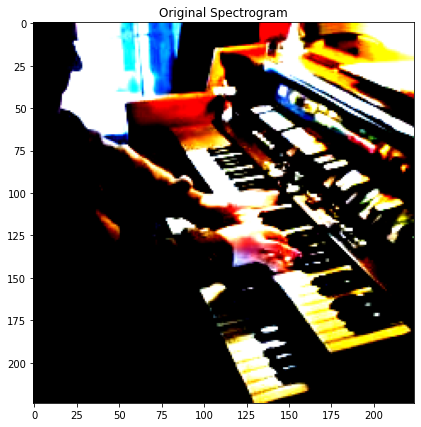

0.020408163
0.13195854


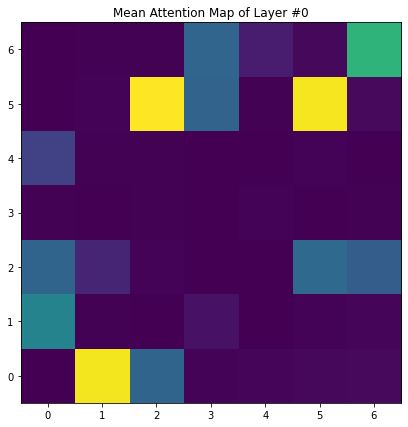

0.020408163
0.24413863


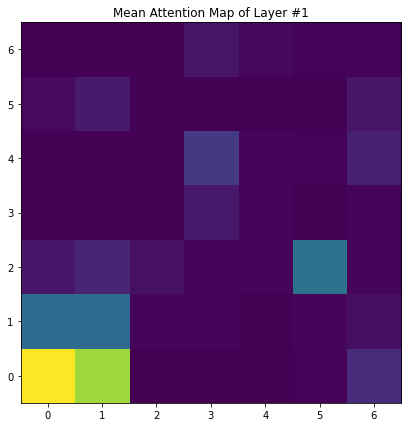

0.020408163
0.2511213


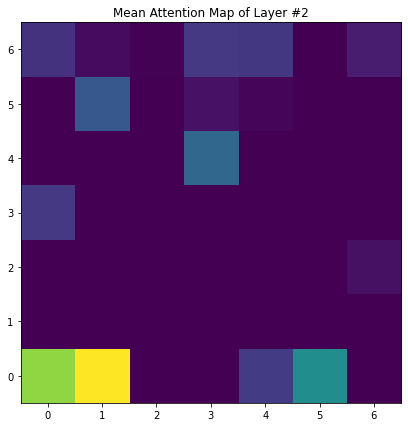

0.020408163
0.29099637


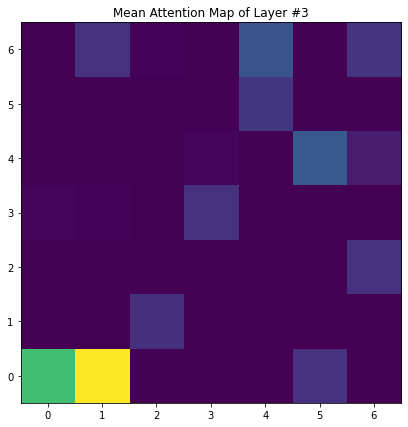

0.020408163
0.11381846


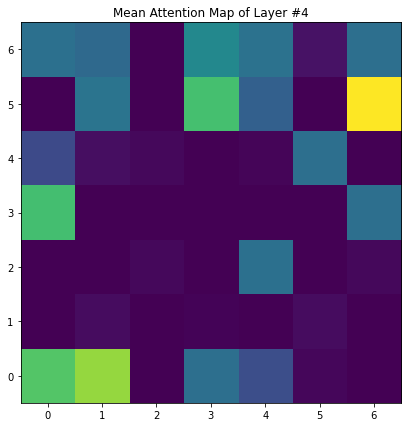

0.020408163
0.15812586


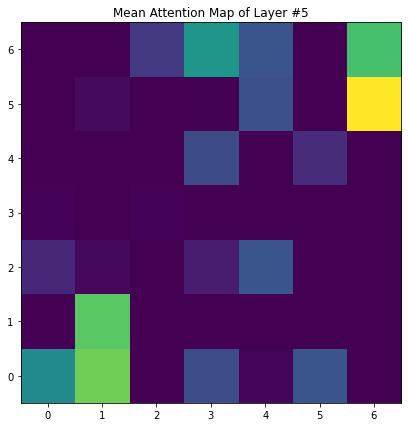

0.020408163
0.12320703


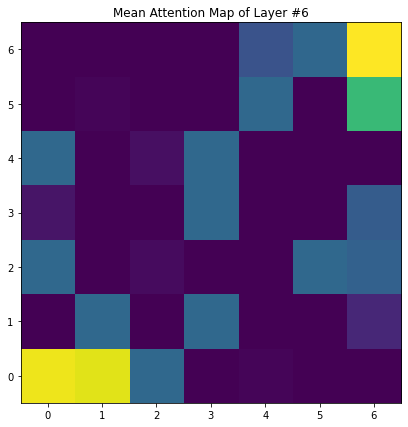

0.020408163
0.125


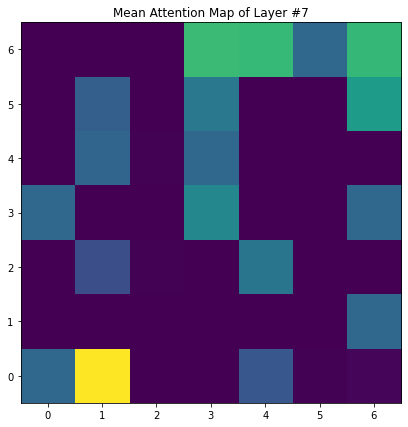

0.020408163
0.09132585


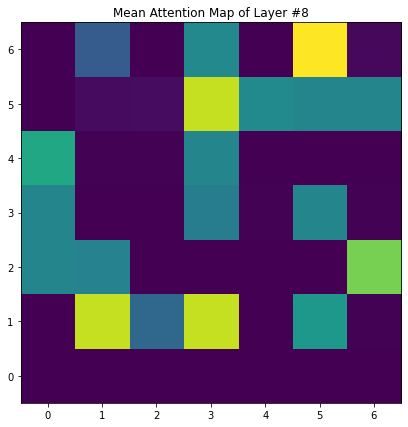

0.020408163
0.12499758


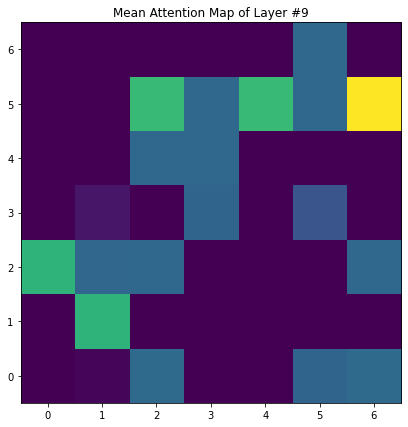

0.020408163
0.16014764


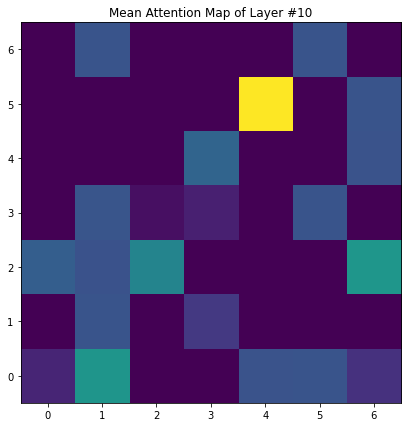

In [21]:
from matplotlib import pyplot as plt
img = torch.einsum('chw->hwc', v.squeeze(0))

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img.squeeze(0).cpu().numpy())
plt.title('Original Spectrogram')
plt.show()
plt.close()

with torch.no_grad():
    with autocast():
        att_list = model.module.visualize_v(v)
for i in range(len(att_list)):
    att_list[i] = att_list[i].data.cpu().numpy()
    att_list[i] = np.mean(att_list[i][0], axis=0)
    att_list[i] = np.mean(att_list[i][0:2], axis=0)
    print(np.mean(att_list[i], axis=0))
    print(np.max(att_list[i]))

    att_list[i] = att_list[i].reshape(7, 7)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.imshow(att_list[i], origin='lower')
    plt.title('Mean Attention Map of Layer #{:d}'.format(i))
    plt.show()
    plt.close()

In [32]:
3*224*224, (1* 49* 768) * 1, 49*14*14

(150528, 37632, 9604)

In [17]:
abc=np.zeros([1, 49, 768])
abc.shape[-2] // 16,abc.shape[-1] // 16

(3, 48)

In [28]:

abc=np.zeros([1, 49, 768])


# Visualization of the attention layer

In [15]:
class ModelVis(CAVMAEFT):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)
        B = x.shape[0]
        x = self.patch_embed_a(x)
        x = x + self.modality_a
        x = x + self.pos_embed_a
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.blocks_a:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list
    
model = ModelVis(label_dim=57)
model = torch.nn.DataParallel(model)
sd = torch.load('/mnt/g/My Drive/Thesis/src/pretrained/best_audio_model_ft.pth', map_location=device)
#sd = torch.load('/mnt/g/My Drive/Thesis/src/pretrained/model_papers.pth', map_location=device)

model.load_state_dict(sd)

Use norm_pix_loss:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])


<All keys matched successfully>

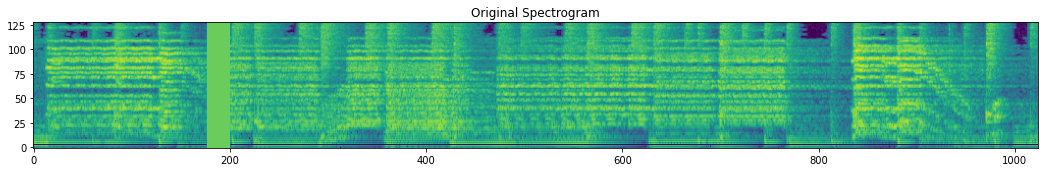

0.001953125
0.061254263


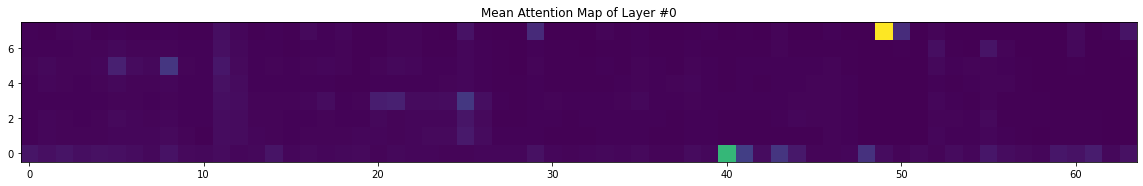

0.001953125
0.10544829


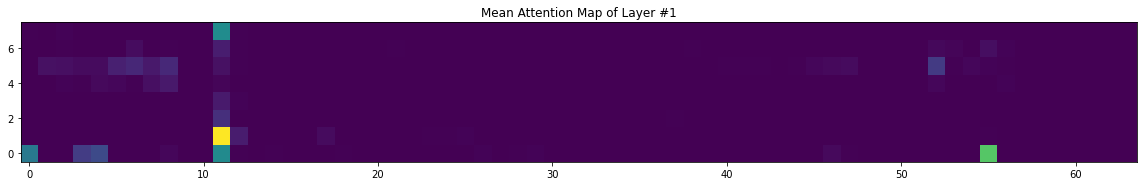

0.0019531249
0.10663722


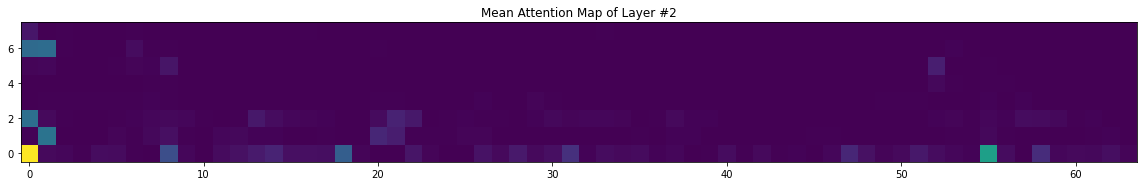

0.001953125
0.102366455


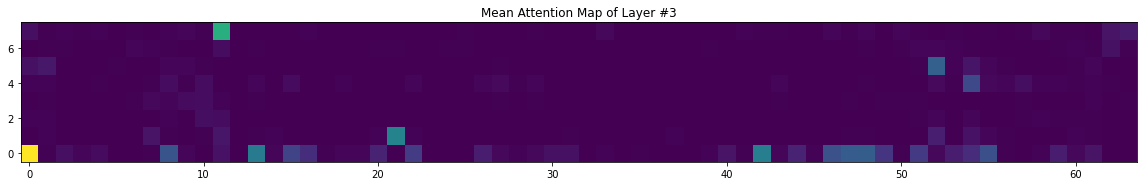

0.001953125
0.08838461


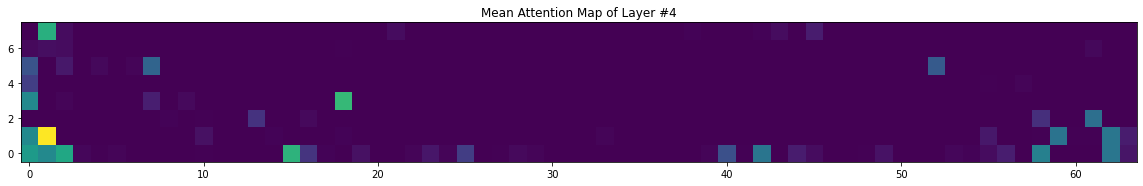

0.001953125
0.22716278


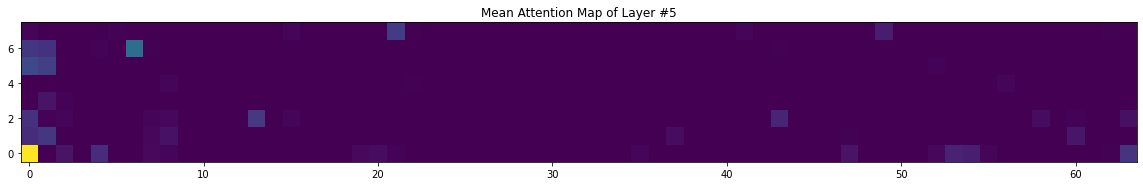

0.001953125
0.29325742


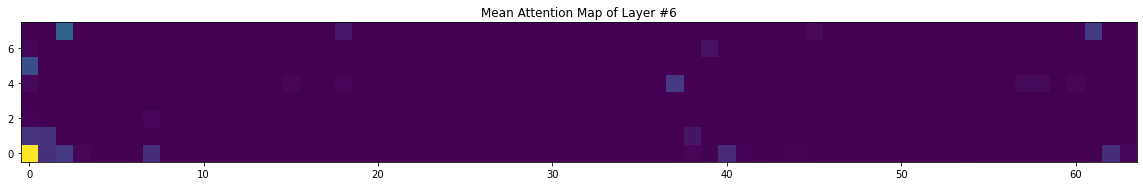

0.001953125
0.07994961


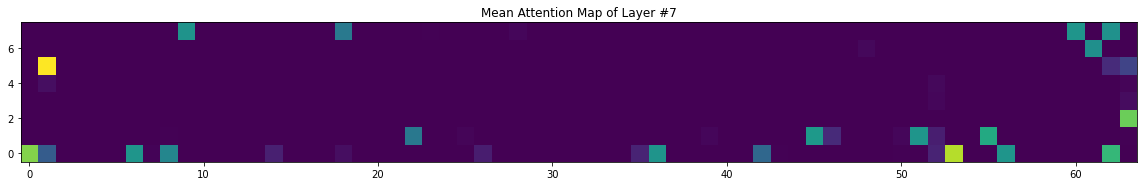

0.001953125
0.085456416


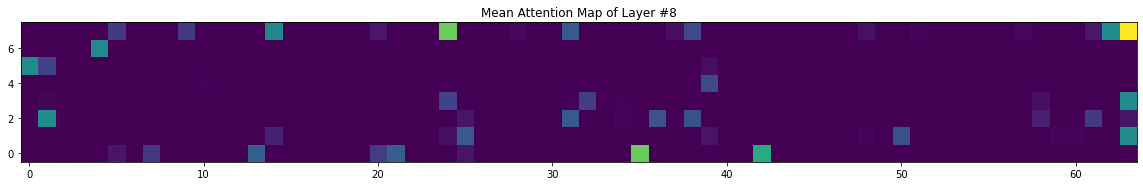

0.0019531249
0.18769562


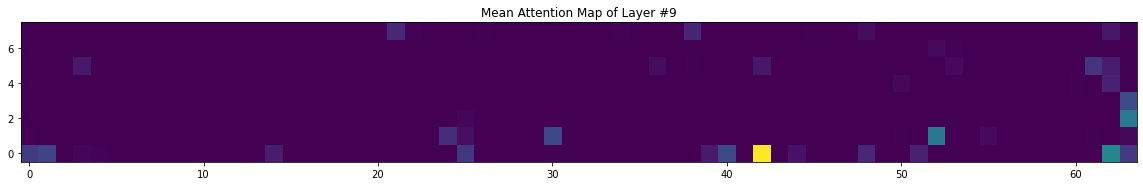

0.001953125
0.37500402


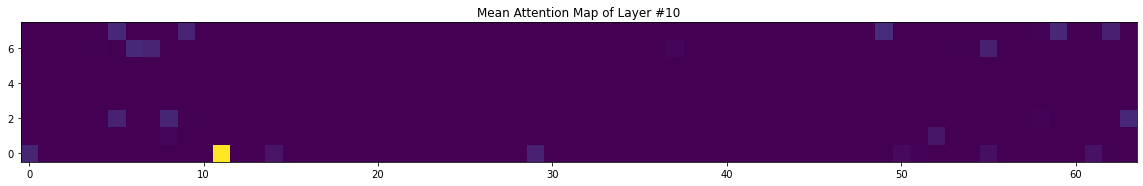

In [16]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(18, 5))
ax.imshow(a_input[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()

with torch.no_grad():
    with autocast():
        att_list = model.module.forward_visualization(a)
for i in range(len(att_list)):
    att_list[i] = att_list[i].data.cpu().numpy()
    att_list[i] = np.mean(att_list[i][0], axis=0)
    att_list[i] = np.mean(att_list[i][0:2], axis=0)
    print(np.mean(att_list[i], axis=0))
    print(np.max(att_list[i]))
    att_list[i] = att_list[i].reshape(8, 64)
    fig, ax = plt.subplots(figsize=(20, 17))
    ax.imshow(att_list[i], origin='lower')
    plt.title('Mean Attention Map of Layer #{:d}'.format(i))
    plt.show()
    plt.close()

In [186]:
with torch.no_grad():
    for i, (a_input, v_input, label_index, labels) in enumerate(tr_loader):
        a = a_input.to(device)
        v = v_input.to(device)
        with autocast():
            att_list = model.module.forward_visualization(a)
        
        for i in range(len(att_list)):
            att_list[i] = att_list[i].data.cpu().numpy()
            att_list[i] = np.mean(att_list[i][0], axis=0)
            att_list[i] = np.mean(att_list[i][0:2], axis=0)
            print(np.mean(att_list[i], axis=0))
            print(np.max(att_list[i]))
            print()
    

0.001953125
0.086212315

0.0019531249
0.14421657

0.0019531249
0.06877123

0.001953125
0.08091498

0.001953125
0.08723531

0.001953125
0.12369336

0.001953125
0.086349756

0.001953125
0.09644666

0.001953125
0.17065935

0.0019531252
0.6788929

0.001953125
0.7083334

0.001953125
0.10640979

0.001953125
0.11582197

0.001953125
0.08699773

0.0019531249
0.09770583

0.001953125
0.08548184

0.001953125
0.083425105

0.001953125
0.08431061

0.001953125
0.120366514

0.001953125
0.29184103

0.001953125
0.91486096

0.001953125
0.75

0.001953125
0.01725512

0.001953125
0.14215848

0.0019531249
0.1387194

0.001953125
0.118256345

0.001953125
0.18157358

0.0019531249
0.22805917

0.001953125
0.1999794

0.0019531249
0.16067748

0.001953125
0.23009878

0.0019531248
0.54166645

0.0019531252
0.6666667

0.001953125
0.071827814

0.001953125
0.1323576

0.001953125
0.12048793

0.001953125
0.08559561

0.001953125
0.14586262

0.001953125
0.09265912

0.0019531249
0.13310465

0.0019531249
0.08369546

0.001953125

In [11]:
class ModelVis(CAVMAEFT):
    
    def random_masking_unstructured(self, x, mask_ratio):
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def visualize_a(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)
        B = x.shape[0]
        x = self.patch_embed_a(x)
        x = x + self.modality_a
        x = x + self.pos_embed_a
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.blocks_a:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list
    
    def visualize_v(self,x):
        v = self.patch_embed_v(x)
        v = v + self.pos_embed_v
        v = v + self.modality_v
        #v, mask_v, ids_restore_v = self.random_masking_unstructured(v, mask_ratio=0.75)
        att_list = []
        for blk in self.blocks_v:
            cur_att = self.get_att_map(blk, v)
            att_list.append(cur_att)
            v = blk(v)
        return att_list
        # keep only the output patch attention
    def visualize_u(self,a,v):
        x = a.unsqueeze(1)
        x = x.transpose(2, 3)
        B = x.shape[0]
        x = self.patch_embed_a(x)
        x = x + self.modality_a
        x = x + self.pos_embed_a
        
        v = self.patch_embed_v(v)
        v = v + self.pos_embed_v
        v = v + self.modality_v
        
        for blk in self.blocks_a:
            x = blk(x)

        for blk in self.blocks_v:
            v = blk(v)

        x = torch.cat((x, v), dim=1)
        att_list = []
        for blk in self.blocks_u:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list 
        
                    
model = ModelVis(label_dim=57)
model = torch.nn.DataParallel(model)
sd = torch.load('/mnt/g/My Drive/Thesis/src/pretrained/best_audio_model_ft.pth', map_location=device)
model.load_state_dict(sd)

Use norm_pix_loss:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])


<All keys matched successfully>

['steel_guitar']
0.0014124294
0.33728826


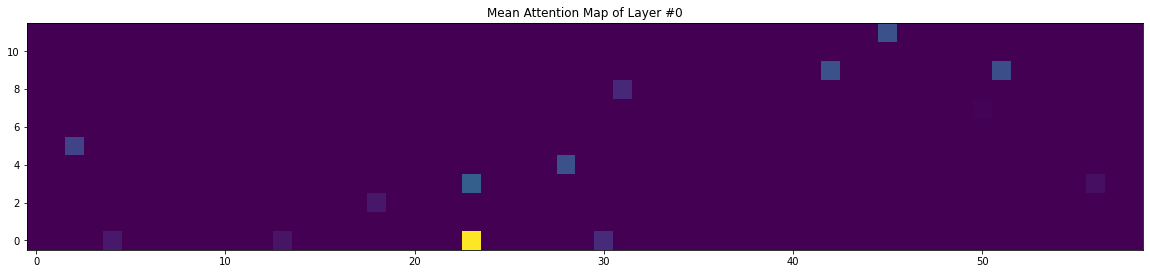

['flute']
0.0014124294
0.16688272


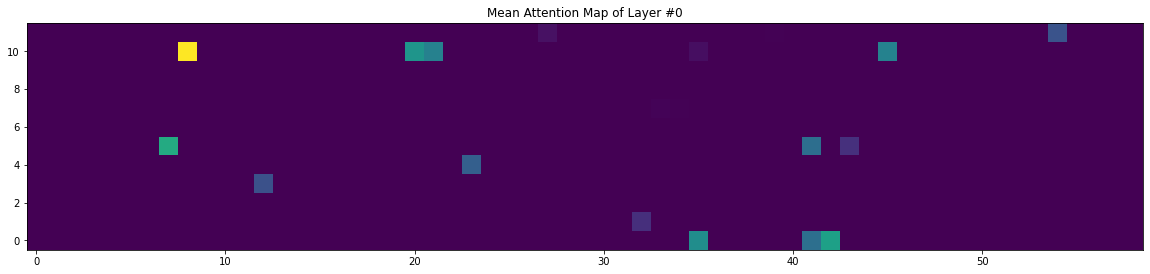

['didgeridoo']
0.0014124294
0.4109109


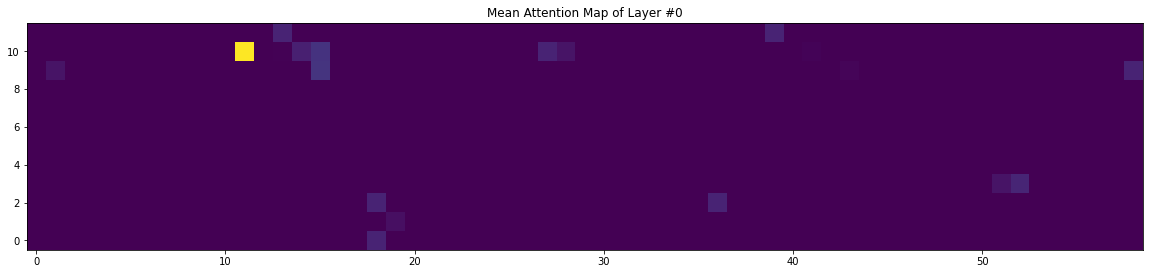

['trombone']
0.0014124294
0.45835638


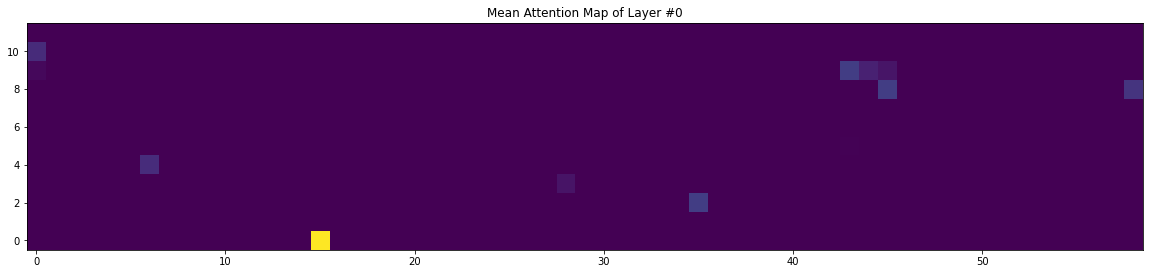

['piano']
0.0014124294
0.20833334


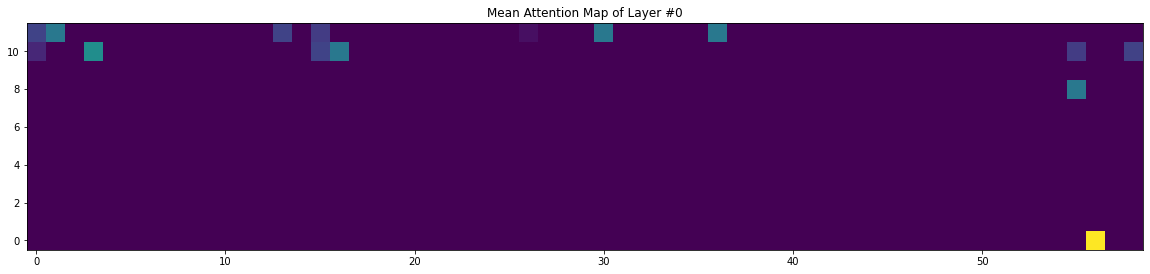

In [12]:
for i, (a_input, v_input, label_index, labels) in enumerate(tr_loader):
    print(labels)
    a = a_input.to(device)
    v = v_input.to(device)
    with torch.no_grad():
        with autocast():
            att_list = model.module.visualize_u(a,v)
    for i in range(len(att_list)):
        att_list[i] = att_list[i].data.cpu().numpy()
        att_list[i] = np.mean(att_list[i][0], axis=0)
        att_list[i] = np.mean(att_list[i][0:2], axis=0)
        print(np.mean(att_list[i], axis=0))
        print(np.max(att_list[i]))
        att_list[i] = att_list[i].reshape(12, 59)
        fig, ax = plt.subplots(figsize=(20, 17))
        ax.imshow(att_list[i], origin='lower')
        plt.title('Mean Attention Map of Layer #{:d}'.format(i))
        plt.show()
        plt.close()